# 1. Introduction

This notebook predics Cervical Spine Fractures from Computed Tomography (CT) scans.

**Dataset**
The dataset  is made up of roughly 3000 CT studies (https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/overview/acknowledgements).

We need to predict the probability of fracture for each of the seven cervical vertebrae labeled C1, C2, C3, C4, C5, C6 and C7 as well as an overall probability of any fractures in the cervical spine. This means there will be 8 rows per image id in the submission file. Note that fractures in the skull base, thoracic spine, ribs, and clavicles are ignored.
    
The metric to evaluate performance is a weighted multi-label logarithmic loss (averaged across all patients).

In [40]:
# To read compressed dicom files:
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns
sns.set(font_scale=1.5)
import cv2
import os
from os import listdir
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings

# 2. Data

In [42]:
# Load metadata
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")
ss = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv")

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('ss shape:', ss.shape)
print('')
train_df.head(10)

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
ss shape: (3, 2)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


In [43]:
train_bbox.head(10)

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
5,1.2.826.0.1.3680043.10051,213.56364,216.71419,25.13455,47.92717,138
6,1.2.826.0.1.3680043.10051,209.00000,214.57591,36.06131,51.56834,139
7,1.2.826.0.1.3680043.10051,204.25455,212.24727,47.47636,57.71635,140
8,1.2.826.0.1.3680043.10051,205.00000,213.87342,45.00000,59.12658,141
9,1.2.826.0.1.3680043.10051,205.18545,214.76814,42.89892,63.43364,142


In [44]:
test_df.head(10)

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [45]:
ss.head()

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


# 3. EDA

(0.0, 2800.0)

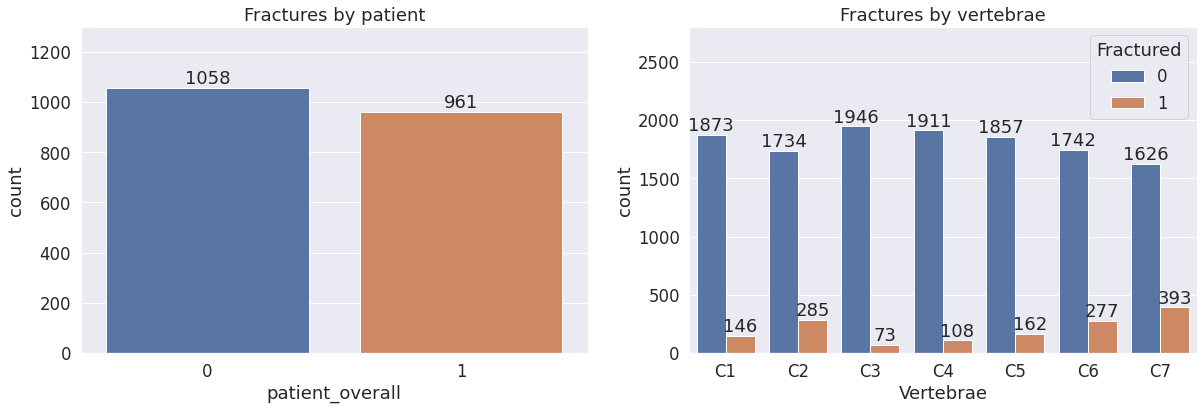

In [46]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])

# Unpivot train_df for plotting
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])

(0.0, 1300.0)

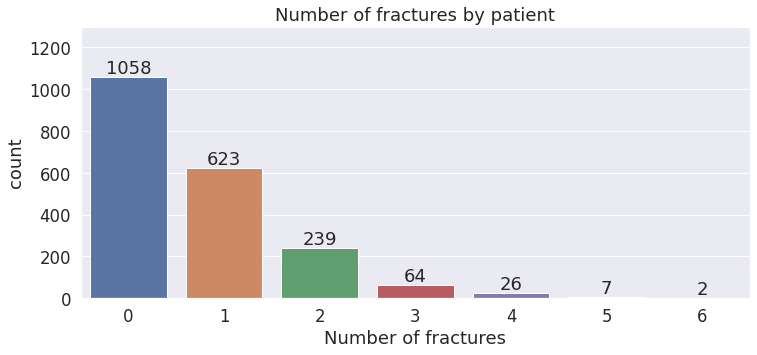

In [47]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')
plt.ylim([0,1300])

Text(0.5, 1.0, 'Correlations')

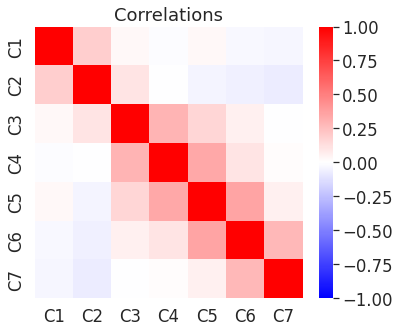

In [48]:
# Heatmap of correlations
plt.figure(figsize=(6,5))
sns.heatmap(train_df[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlations')

## Study IDs

For the IDs, only the **number after the last decimal place** is important. 

In [49]:
# Example
train_df['StudyInstanceUID'][0]

'1.2.826.0.1.3680043.6200'

In [50]:
# Find unique numbers in study id's
for i in range(7):
    print(train_df['StudyInstanceUID'].map(lambda x : x.split('.')[i]).unique())

['1']
['2']
['826']
['0']
['1']
['3680043']
['6200' '27262' '21561' ... '14341' '12053' '18786']


# 4. Train images

DICOM

Use the pydicom library to open and analyze these files.

In [51]:
ex_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001/101.dcm"
dcm_example = pydicom.dcmread(ex_path)
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10001.1.101
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10001.1.101
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '175846.512627'
(0010, 0010) Patient's Name                      PN: '10001'
(0010, 0020) Patient ID                          LO: '10001'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

The **image data** is stored in an array under **'Pixel Data'**. Everything else is **metadata**.

# 5. Segmentations

This helps us identify which **vertebrae** is being shown in each image.

In [52]:
ex_path2 = f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{patient_id}.nii"
nii_example = nib.load(ex_path2)

# Convert to numpy array
seg = nii_example.get_fdata()
seg.shape

(512, 512, 331)

In [53]:
# Align orientation with images
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
seg.shape

(331, 512, 512)

Exploring Masks

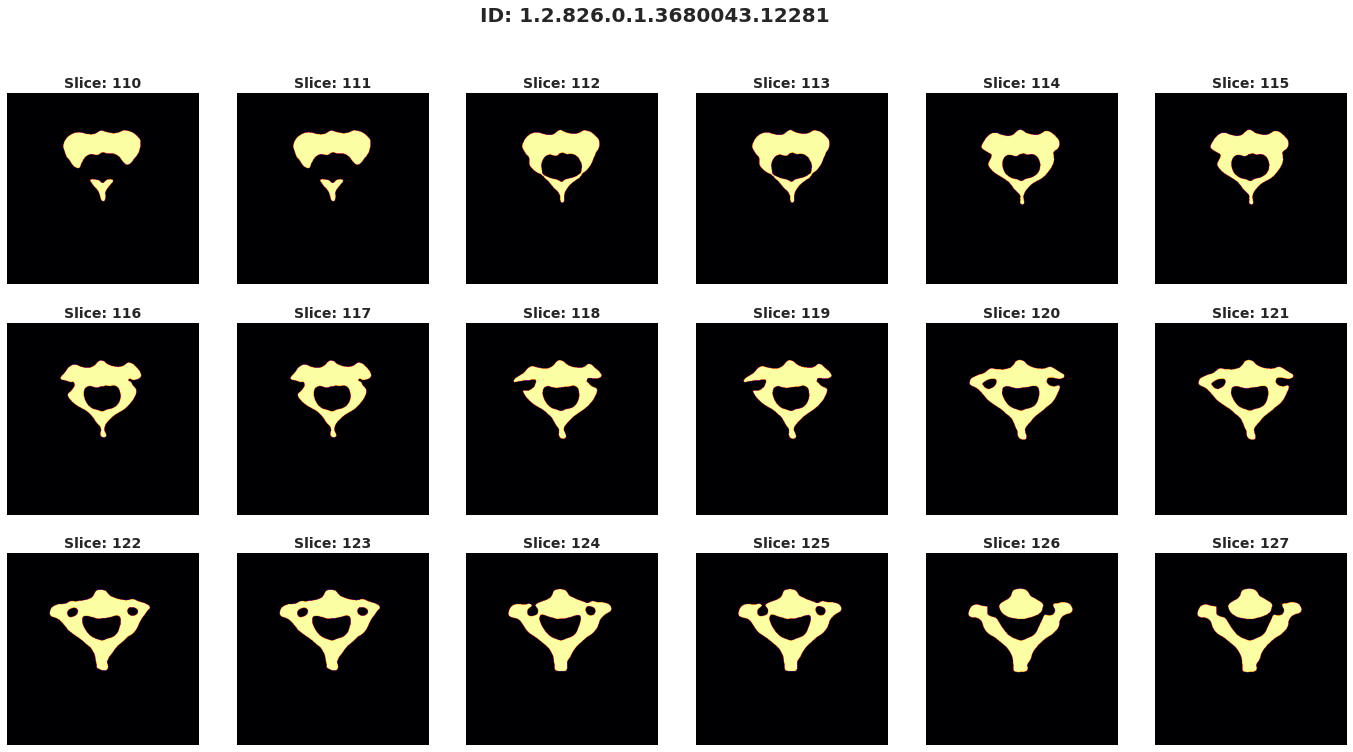

In [54]:
# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

for i in range(start,start+18):
    mask = seg[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='inferno')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')
    
#Masks give us  **location** of the vertebrae and which vertebrae are in the images.

In [55]:
np.unique(seg[116])

array([0., 2.])

Unfortunately, we don't have segmentations for the whole train set.

In [56]:
# Number of cases with masks
seg_paths = glob(f"{base_path}/segmentations/*")
print(f'Number of cases with segmentations: {len(seg_paths)}, ({np.round(100*len(seg_paths)/len(train_df),1)}%)')

# train a segmentation model like UNet to predict segmentation masks for the rest of the images.

Number of cases with segmentations: 87, (4.3%)


# 6. Extract metadata

In [57]:
def get_observation_data(path):

    dataset = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "Rows" : dataset.get("Rows"),
        "Columns" : dataset.get("Columns"),
        "SOPInstanceUID" : dataset.get("SOPInstanceUID"),
        "ContentDate" : dataset.get("ContentDate"),
        "SliceThickness" : dataset.get("SliceThickness"),
        "InstanceNumber" : dataset.get("InstanceNumber"),
        "ImagePositionPatient" : dataset.get("ImagePositionPatient"),
        "ImageOrientationPatient" : dataset.get("ImageOrientationPatient"),
    }

    # String columns
    str_columns = ["SOPInstanceUID", "ContentDate", 
                   "SliceThickness", "InstanceNumber"]
    for k in str_columns:
        observation_data[k] = str(dataset.get(k)) if k in dataset else None

    return observation_data

def get_metadata():
    #saves metadata from files into a dataframe
    exceptions = 0
    dicts = []

    for k in tqdm(range(len(train_df))):
        if (k % 100)==0:
            print(f'Iteration: {k}')
            
        dt = train_df.iloc[k, :]

        # Get all .dcm paths for this Instance
        dcm_paths = glob(f"{base_path}/train_images/{dt.StudyInstanceUID}/*")

        for path in dcm_paths:
            try:
                # Get datasets
                dataset = get_observation_data(path)
                dicts.append(dataset)
            except Exception as e:
                exceptions += 1
                continue

    # Convert into df
    meta_train_data = pd.DataFrame(data=dicts, columns=md_example.keys())
    
    # Export information
    meta_train_data.to_csv("meta_train.csv", index=False)
    
    print(f"Metadata created. Number of total fails: {exceptions}.")

In [58]:
# Example
md_example = get_observation_data(ex_path)
pprint(md_example)

{'Columns': 512,
 'ContentDate': '20220727',
 'ImageOrientationPatient': [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000],
 'ImagePositionPatient': [-52.308, -27.712, -55.218],
 'InstanceNumber': '101',
 'Rows': 512,
 'SOPInstanceUID': '1.2.826.0.1.3680043.10001.1.101',
 'SliceThickness': '0.625000'}


Explore Metadata

In [59]:
# Read in saved metadata
meta_train = pd.read_csv("../input/rsna-2022-spine-fracture-detection-metadata/meta_train.csv")
meta_train["StudyInstanceUID"] = meta_train["SOPInstanceUID"].apply(lambda x: ".".join(x.split(".")[:-2]))
print('meta_train shape:', meta_train.shape)
meta_train.head(10)

meta_train shape: (711601, 9)


,Rows,Columns,SOPInstanceUID,ContentDate,SliceThickness,InstanceNumber,ImagePositionPatient,ImageOrientationPatient,StudyInstanceUID
0,512,512,1.2.826.0.1.3680043.6200.1.240,20220727,1.0,240,"[-118.530, -103.5302, 143.30]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
1,512,512,1.2.826.0.1.3680043.6200.1.12,20220727,1.0,12,"[-118.530, -103.5302, 325.70]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
2,512,512,1.2.826.0.1.3680043.6200.1.210,20220727,1.0,210,"[-118.530, -103.5302, 167.30]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
3,512,512,1.2.826.0.1.3680043.6200.1.120,20220727,1.0,120,"[-118.530, -103.5302, 239.30]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
4,512,512,1.2.826.0.1.3680043.6200.1.208,20220727,1.0,208,"[-118.530, -103.5302, 168.90]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
5,512,512,1.2.826.0.1.3680043.6200.1.141,20220727,1.0,141,"[-118.530, -103.5302, 222.50]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
6,512,512,1.2.826.0.1.3680043.6200.1.18,20220727,1.0,18,"[-118.530, -103.5302, 320.90]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
7,512,512,1.2.826.0.1.3680043.6200.1.9,20220727,1.0,9,"[-118.530, -103.5302, 328.10]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
8,512,512,1.2.826.0.1.3680043.6200.1.97,20220727,1.0,97,"[-118.530, -103.5302, 257.70]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
9,512,512,1.2.826.0.1.3680043.6200.1.95,20220727,1.0,95,"[-118.530, -103.5302, 259.30]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200


Text(0.5, 1.02, 'Image sizes in train images')

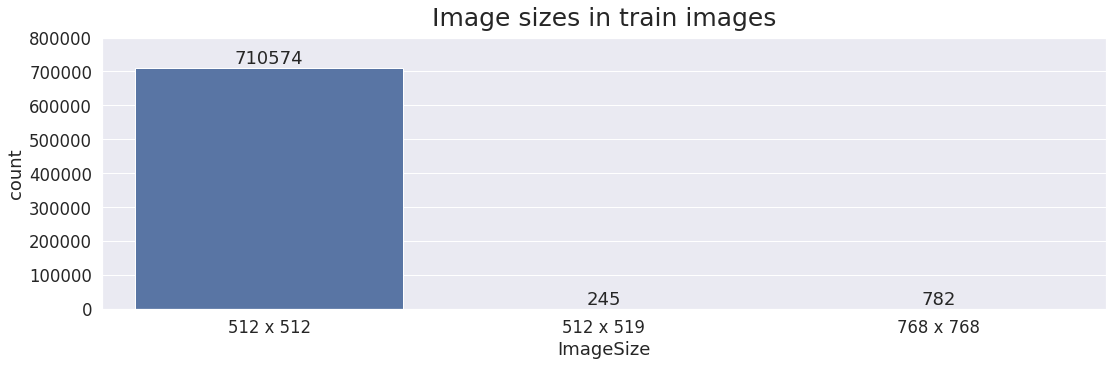

In [60]:
# Image size
meta_train["ImageSize"] = meta_train["Rows"].astype(str) + " x " + meta_train["Columns"].astype(str)

# Plot image sizes
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train, x="ImageSize")
for container in ax.containers:
    ax.bar_label(container)
plt.ylim([0,800000])
plt.title('Image sizes in train images', fontsize=25, y=1.02)

#Almost all images have size 512x512
#Resize all images to 512 x 512 for consistency

**Content Date**

In [61]:
# Unique values
meta_train['ContentDate'].unique()
#Drope ContentDate since all values are equal

array([20220727])

In [62]:
meta_train.drop('ContentDate', axis=1, inplace=True)

In [63]:
#Slice Thickness
meta_train["SliceThickness"].unique()

array([1.        , 0.5       , 0.625     , 0.6       , 0.67      ,
       0.9       , 0.8       , 0.488281  , 0.75      , 0.664062  ,
       0.60000002])

Text(0.5, 1.02, 'Slice thickness distribution')

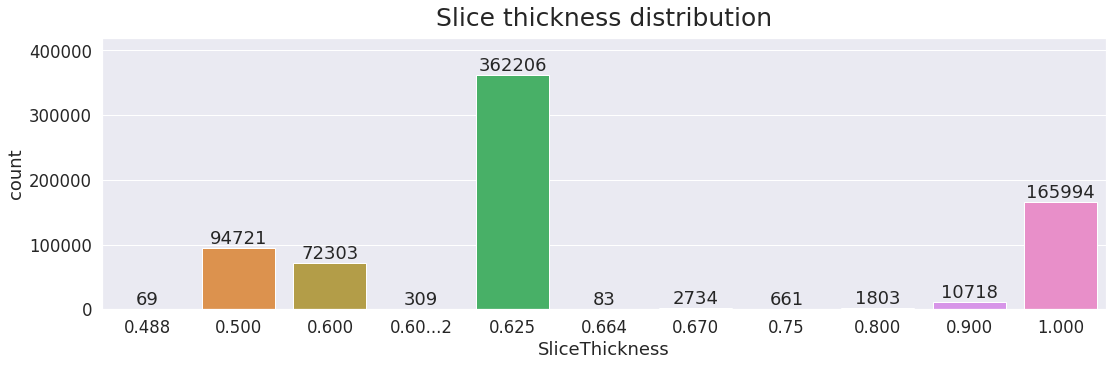

In [64]:
# Plot slice thickness
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train, x="SliceThickness")
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels(['0.488','0.500','0.600','0.60...2','0.625','0.664','0.670','0.75','0.800','0.900','1.000'])
plt.ylim([0,420000])
plt.title('Slice thickness distribution', fontsize=25, y=1.02)

**Number of slices per scan**

Text(0.5, 0, 'Number of Slices')

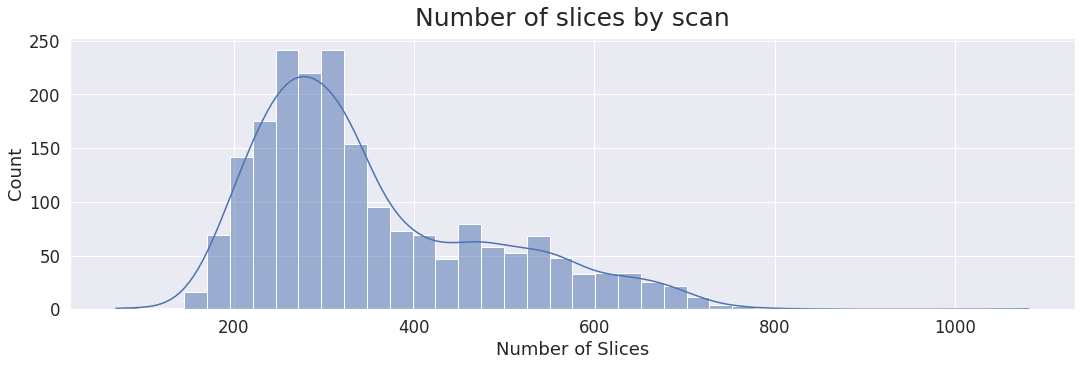

In [65]:
# Slice counts
slice_counts = meta_train["StudyInstanceUID"].value_counts().reset_index()
slice_counts.columns = ["StudyInstanceUID", "count"]

# Distribution of slices counts
plt.figure(figsize=(18, 5))
sns.histplot(data=slice_counts, x="count", kde=True, bins=40)
plt.title("Number of slices by scan", size=25, y=1.02)
plt.xlabel("Number of Slices", size = 18)

**Image Position Patient**

In [66]:
# Extract x, y, z coordinates of position vector
meta_train['ImagePositionPatient_x'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[0]))
meta_train['ImagePositionPatient_y'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[1]))
meta_train['ImagePositionPatient_z'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[2]))

Text(0.5, 1.02, 'z-coordinate')

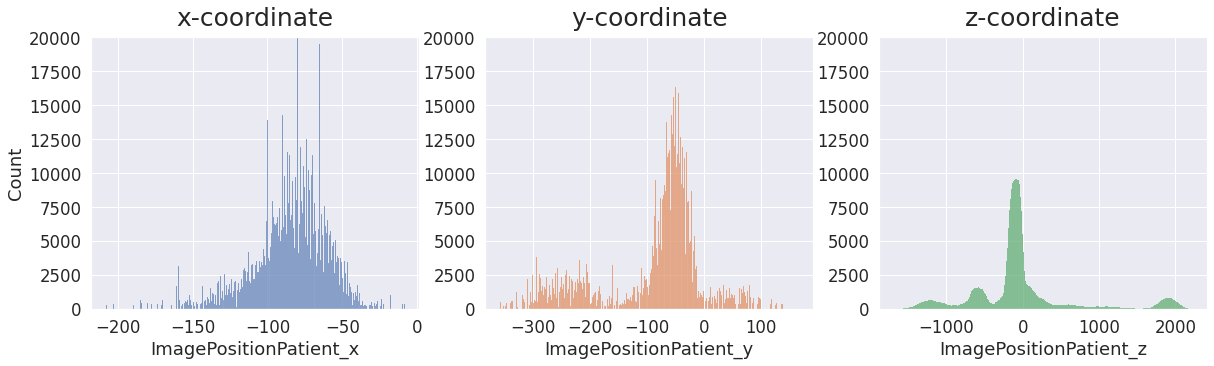

In [67]:
# Plot position coordinates
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(meta_train['ImagePositionPatient_x'])
plt.ylim([0,20000])
plt.title('x-coordinate', fontsize=25, y=1.02)

plt.subplot(1,3,2)
sns.histplot(meta_train['ImagePositionPatient_y'], color='C1')
plt.ylabel('')
plt.ylim([0,20000])
plt.title('y-coordinate', fontsize=25, y=1.02)

plt.subplot(1,3,3)
sns.histplot(meta_train['ImagePositionPatient_z'], color='C2')
plt.ylabel('')
plt.ylim([0,20000])
plt.title('z-coordinate', fontsize=25, y=1.02)

**Image Orientation Patient**

This feature tells us coordinates for the position of the patient in the scanner i.e. rotation of image.

In [68]:
meta_train['ImageOrientationPatient'].nunique()

400

In [69]:
meta_train['ImageOrientationPatient'].unique()[:5]

array(['[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000]',
       '[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]',
       '[1, 0, 0, 0, 1, 0]',
       '[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, -0.000000]',
       '[0.997007, -2.5917e-002, 7.2833e-002, 2.2466e-002, 0.998604, 4.7813e-002]'],
      dtype=object)

In [70]:
# Clean metadata
meta_train_clean = meta_train.drop(['SOPInstanceUID','ImagePositionPatient','ImageOrientationPatient','ImageSize'], axis=1)
meta_train_clean.rename(columns={"Rows": "ImageHeight", "Columns": "ImageWidth","InstanceNumber": "Slice"}, inplace=True)
meta_train_clean = meta_train_clean[['StudyInstanceUID','Slice','ImageHeight','ImageWidth','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']]
meta_train_clean.sort_values(by=['StudyInstanceUID','Slice'], inplace=True)
meta_train_clean.reset_index(drop=True, inplace=True)

meta_train_clean.head(10)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782
5,1.2.826.0.1.3680043.10001,6,512,512,0.625,-52.308,-27.712,4.157
6,1.2.826.0.1.3680043.10001,7,512,512,0.625,-52.308,-27.712,3.532
7,1.2.826.0.1.3680043.10001,8,512,512,0.625,-52.308,-27.712,2.907
8,1.2.826.0.1.3680043.10001,9,512,512,0.625,-52.308,-27.712,2.282
9,1.2.826.0.1.3680043.10001,10,512,512,0.625,-52.308,-27.712,1.657


The **cleaned version** of this metadata is also in my dataset [here](https://www.kaggle.com/datasets/samuelcortinhas/rsna-2022-spine-fracture-detection-metadata).

# 7. Bounding boxes

Box Distributions

In [71]:
print(f'Patients with bounding box measurements: {train_bbox["StudyInstanceUID"].nunique()} ({np.round(100*train_bbox["StudyInstanceUID"].nunique()/len(train_df),1)} %)')

Patients with bounding box measurements: 235 (11.6 %)


The bounding boxes are only provided for a portion of the patients with fractures.

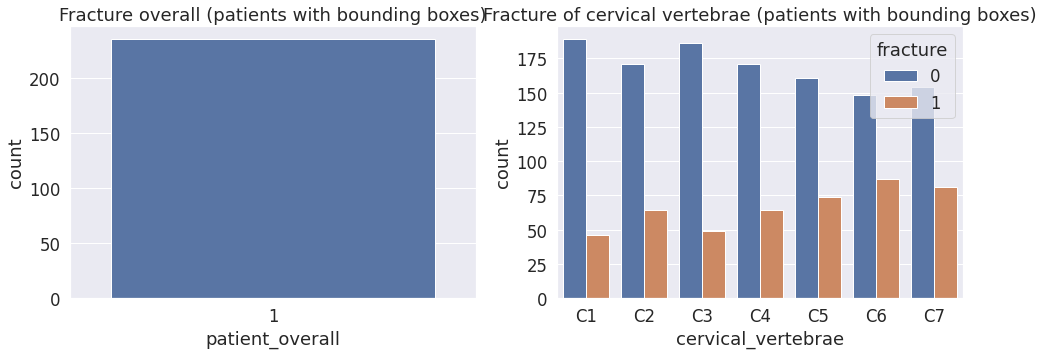

In [72]:
train_df_bbox = train_df[train_df["StudyInstanceUID"].isin(train_bbox["StudyInstanceUID"])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x="patient_overall", data=train_df_bbox, ax=ax1)
ax1.set_title("Fracture overall (patients with bounding boxes)")

train_df_bbox_melt = pd.melt(train_df_bbox, id_vars=["StudyInstanceUID", "patient_overall"], var_name="cervical_vertebrae", value_name="fracture")
sns.countplot(x="cervical_vertebrae", hue="fracture", data=train_df_bbox_melt, ax=ax2)
ax2.set_title("Fracture of cervical vertebrae (patients with bounding boxes)")
plt.show()

Text(0.5, 0, 'Number of bboxes')

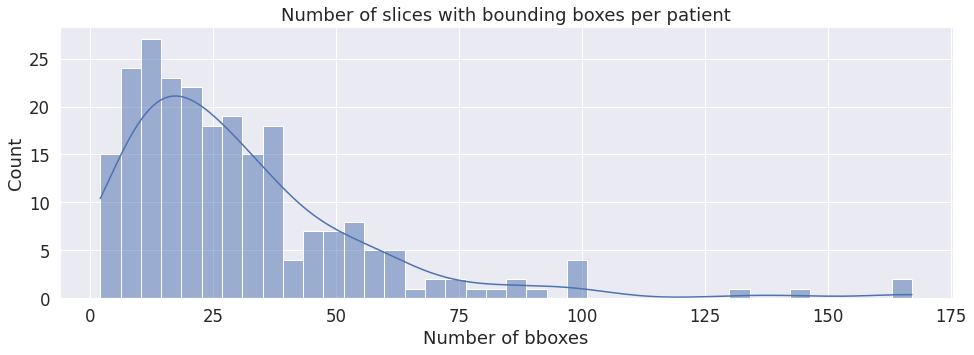

In [73]:
plt.figure(figsize=(16,5))
sns.histplot(train_bbox["StudyInstanceUID"].value_counts().values, kde=True, bins=40)
plt.title('Number of slices with bounding boxes per patient')
plt.xlabel('Number of bboxes')

Text(0.5, 1.0, 'Width and heights')

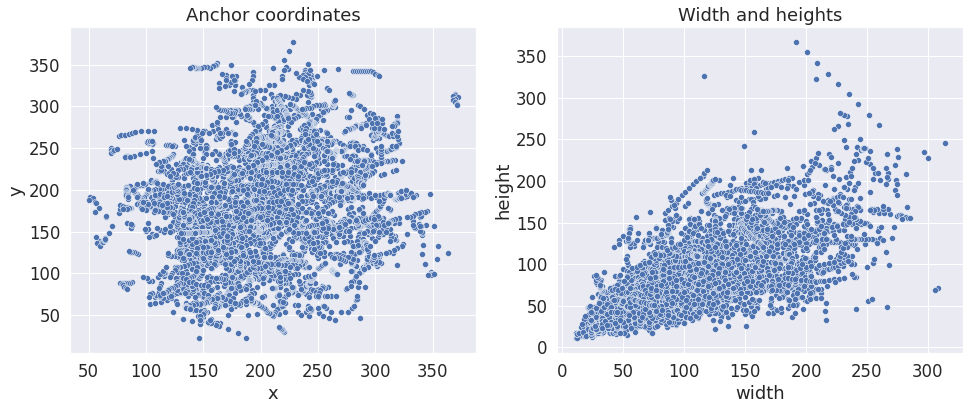

In [74]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(data=train_bbox, x='x', y='y')
plt.title('Anchor coordinates')

plt.subplot(1,2,2)
sns.scatterplot(data=train_bbox, x='width', y='height')
plt.title('Width and heights')

Examples of Fractures

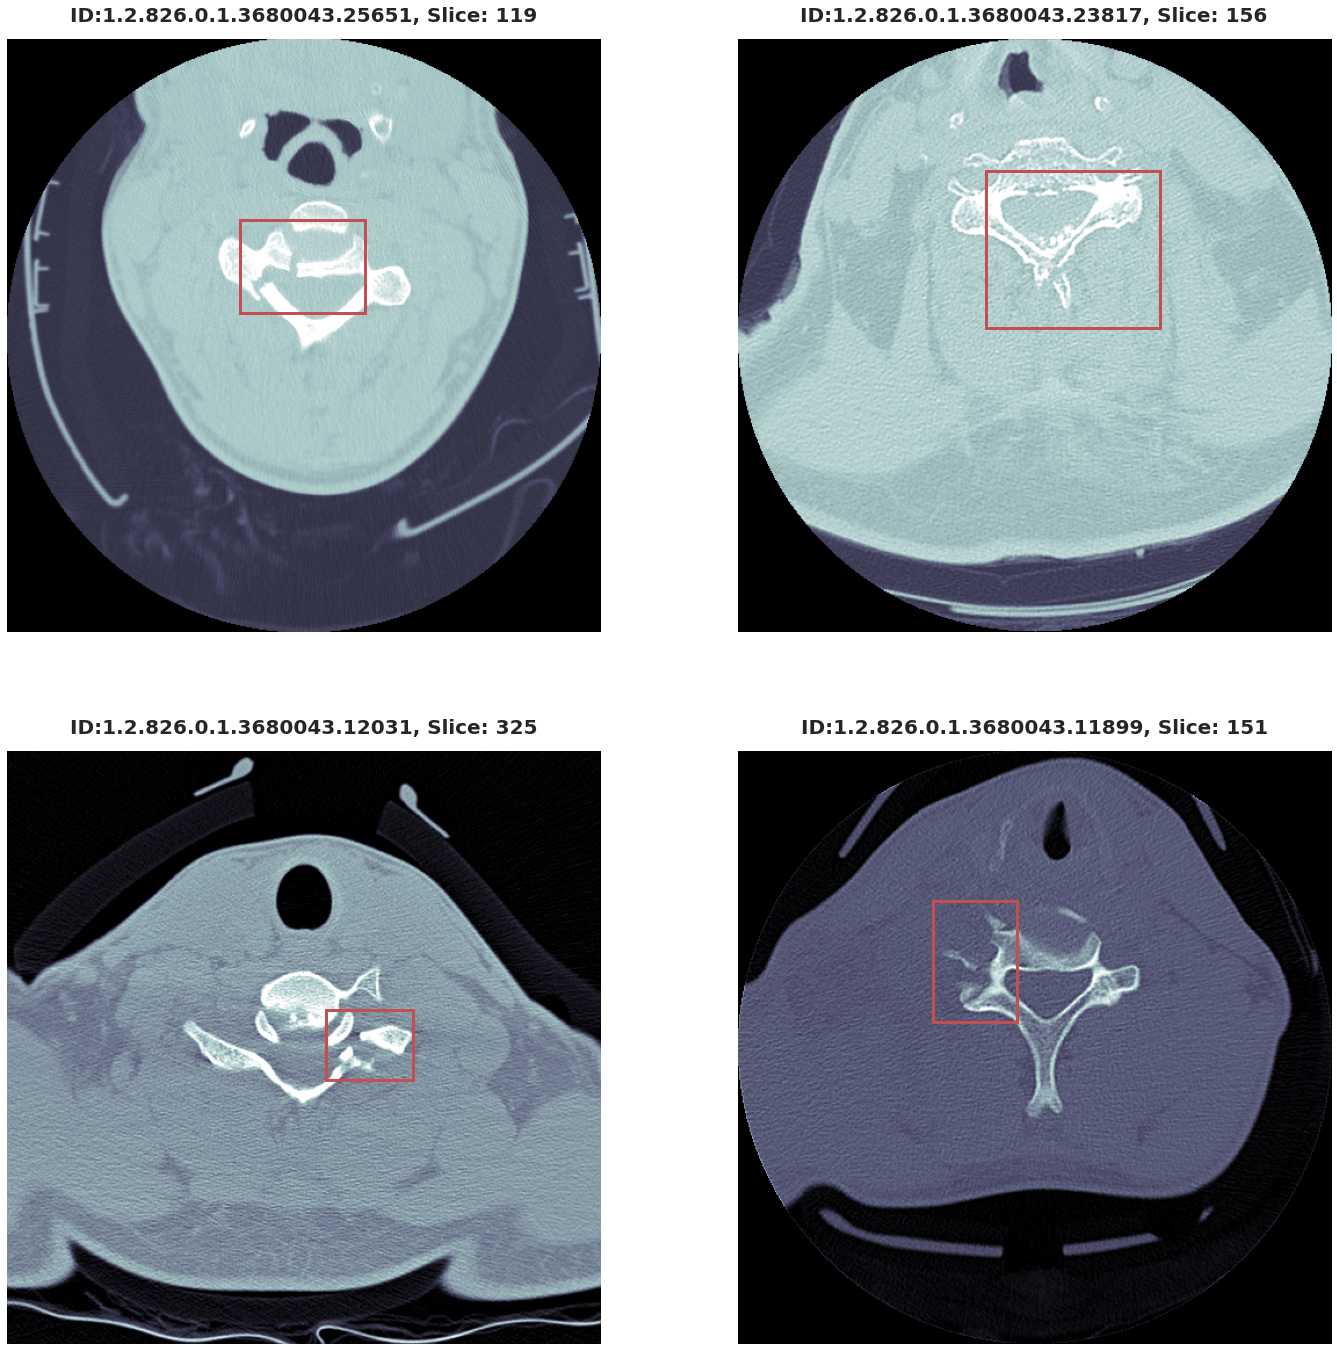

In [75]:
def plot_fracture(slice_num,bbox_id,ax_id1,ax_id2):
    file = pydicom.dcmread(f"{base_path}/train_images/{bbox_id}/{slice_num}.dcm")
    img = apply_voi_lut(file.pixel_array, file)
    info = train_bbox[(train_bbox['StudyInstanceUID']==bbox_id)&(train_bbox['slice_number']==slice_num)]
    rect = patches.Rectangle((float(info.x), float(info.y)), float(info.width), float(info.height), linewidth=3, edgecolor='r', facecolor='none')

    axes[ax_id1,ax_id2].imshow(img, cmap="bone")
    axes[ax_id1,ax_id2].add_patch(rect)
    axes[ax_id1,ax_id2].set_title(f"ID:{bbox_id}, Slice: {slice_num}", fontsize=20, weight='bold',y=1.02)
    axes[ax_id1,ax_id2].axis('off')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,24))
plot_fracture(119,'1.2.826.0.1.3680043.25651',0,0)
plot_fracture(156,'1.2.826.0.1.3680043.23817',0,1)
plot_fracture(325,'1.2.826.0.1.3680043.12031',1,0)
plot_fracture(151,'1.2.826.0.1.3680043.11899',1,1)

# 8. Solution

Submission

In [76]:
# Put more weight on positive predictions
def scale_up(q):
    return 2*q/(1+q)

preds = train_df.mean(numeric_only=True).map(scale_up).to_dict()
ss['fractured'] = test_df['prediction_type'].map(preds)
ss.to_csv('submission.csv', index=False)
ss.head(3)

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.134873
1,1.2.826.0.1.3680043.10454_C1,0.134873
2,1.2.826.0.1.3680043.10690_C1,0.134873
